# TensorFlow word2vec Tutorial - Basic
From here: https://github.com/tensorflow/tensorflow/blob/r1.5/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Basic word2vec example."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

# Step 1: Download the data.

In [12]:
url = 'http://mattmahoney.net/dc/'

# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  local_filename = os.path.join(gettempdir(), filename)
  if not os.path.exists(local_filename):
    local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                   local_filename)
  statinfo = os.stat(local_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + local_filename +
                    '. Can you get to it with a browser?')
  return local_filename

# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

filename = maybe_download('text8.zip', 31344016)

vocabulary = read_data(filename)

print('Data size', len(vocabulary))

Found and verified text8.zip
Data size 17005207


In [15]:
print(type(vocabulary))
# vocabulary is the list of words in the text, or "tokens"
print(vocabulary[:100])

<class 'list'>
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


# Step 2: Build the dictionary and replace rare words with UNK token.

In [17]:
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""

  # count will a list of lists
  count = [['UNK', -1]]
  # add to list most common n_words-1, where n_words is vocabulary size
  # first element in list is above ['UNK',-1]
  # all other elements are tuples, (word, count) for most common words
  count.extend(collections.Counter(words).most_common(n_words - 1))
    
  # initialize dictionary
  # len will start as zero, and increase everytime a new element is added
  # first is 'UNK', then most common, then second most common, etc.
  # so UNK get 0, most common gets 1, second most common 2, and so on
  # so, dict key, value pair will have word for key and number for value, 
  # and the higher the number the less common the word (the lower the more common the word)
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)

  # this counts the number of words in vocabulary that are not in the most common count
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  # updates unknown words, i.e., words in vocabulary that are not in n_words-1 most common  
  count[0][1] = unk_count

  # create inverse key, value pair for dictionary
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

  return data, count, dictionary, reversed_dictionary

# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)

vocabulary_size = 50000
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)

#del vocabulary  # Hint to reduce memory.

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5236, 3083, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


# Step 3: Function to generate a training batch for the skip-gram model.

In [5]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  # initialize batch and label arrays for X and y 
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
  # skip window = how many words to consider left and right
  # span = odd number of words in window of words being analazed
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]

  # create deque (double ended queue - data type capable of pop/extend on either end)
  buffer = collections.deque(maxlen=span)

  # data is the vocabulary, encoded, i.e., a list of numbers, each representing a word
  # set index of list to zero if it's more than length of list
  if data_index + span > len(data):
    data_index = 0
    
  # buffer deque gets "span" words from text
  buffer.extend(data[data_index:data_index + span])
  
  # increment index to list of words in data (text)
  data_index += span

  # batch size = number of word -> word label pairs to generate
  # num skips = how many times to reuse an input to generate a label

  for i in range(batch_size // num_skips):
        
    # context words is index for word around the center of the word window being processed
    context_words = [w for w in range(span) if w != skip_window]
    
    # get random sample of words in the context around the word being processed
    # these words will come from the window around the word being processed
    words_to_use = random.sample(context_words, num_skips)

    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer[:] = data[:span]
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1

  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3083 originated -> 5236 anarchism
3083 originated -> 12 as
12 as -> 3083 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


# Step 4: Build and train a skip-gram model.

In [6]:
data_index = 0

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
        
    # Look up embeddings for inputs.
    
    # embeddings will be initialized with random values from a uniform distribution with values in [-1,1] interval
    # number of rows = size of vocabulary (total number of tokens in text)
    # number of cols = embedding size (defined as 128 above)
    # 
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    # looks up ids in a list of embedding tensors
    # ids are in train_inputs
    # embedding tensors = 2D matrix "embeddings" initialized above
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    # NCE loss means: Noise Contrastive Estimation Loss
    # good resource here: https://datascience.stackexchange.com/questions/13216/intuitive-explanation-of-noise-contrastive-estimation-nce-loss
    
    # nce_weights is 2D matrix initialized with truncated normal values withing 2 std window
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                  tddev=1.0 / math.sqrt(embedding_size)))
    # nce_bias is 1D tensor initialized with zeros
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  
  normalized_embeddings = embeddings / norm
  
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  
  similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()

# Step 5: Begin training.

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  284.694274902
Nearest to this: innkeeper, because, rode, krona, stainless, gobind, dope, observable,
Nearest to while: franchisee, sharpening, pacemaker, spooner, phrased, supremacist, gigahertz, rightmost,
Nearest to often: ensured, supper, suck, toxic, phi, jackals, uke, rshavn,
Nearest to after: buddhists, dealings, linton, fandoms, david, frankly, bertolt, servo,
Nearest to war: xaver, colombia, solvable, recreationally, necessitate, penzance, maris, replenishment,
Nearest to has: fruiting, ud, karnataka, bentsen, gurion, prairie, cics, sixty,
Nearest to not: blackface, dinneen, funding, maureen, tashkent, shalom, concern, spectacularly,
Nearest to all: payton, appreciative, guttural, stamped, transmigration, gherkin, sombre, subgroup,
Nearest to been: terraforming, aspectual, yy, ifor, bakassi, obscure, autistic, severus,
Nearest to of: rice, laments, ambivalence, allegiance, compromise, satsuma, tail, forcibly,
Nearest to their: sequel, wage

Average loss at step  52000 :  5.05113103187
Average loss at step  54000 :  5.19001111317
Average loss at step  56000 :  5.05148828304
Average loss at step  58000 :  5.03969275534
Average loss at step  60000 :  4.95525007486
Nearest to this: which, it, the, that, one, swabian, origination, circ,
Nearest to while: franchisee, and, although, or, is, saw, michelob, dasyprocta,
Nearest to often: also, now, usually, generally, it, supper, not, dribble,
Nearest to after: before, in, kapoor, as, on, under, kifl, for,
Nearest to war: xaver, colombia, ursus, istanbul, michelob, eunuch, homosexual, kapoor,
Nearest to has: had, was, is, have, quarterly, aedh, fruiting, subsequently,
Nearest to not: they, wct, to, it, who, usually, often, agouti,
Nearest to all: some, guttural, these, three, two, aleksandar, akimbo, many,
Nearest to been: be, was, by, severus, ursus, were, reliefs, had,
Nearest to of: in, and, nine, nile, eight, ursus, for, akita,
Nearest to their: its, his, the, her, husserl, ago

# Step 6: Visualize the embeddings.

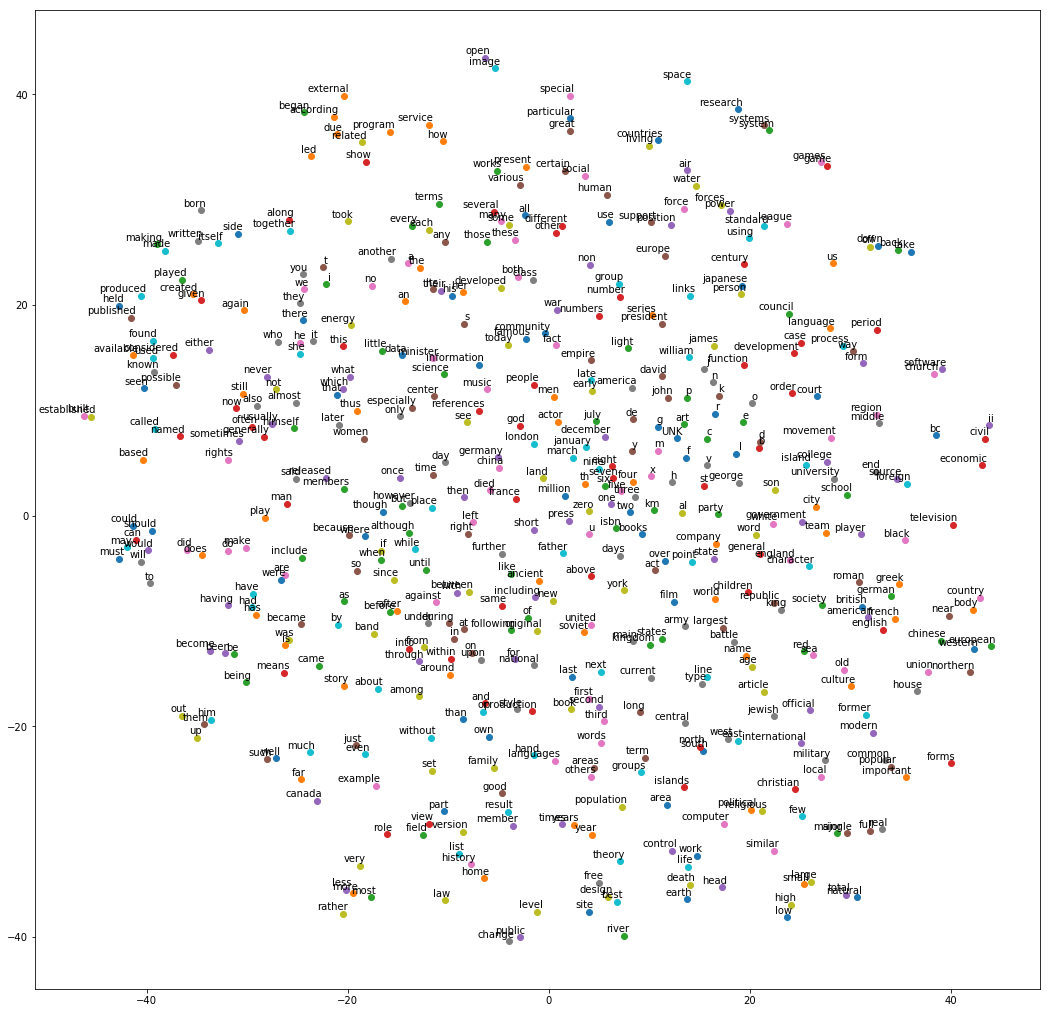

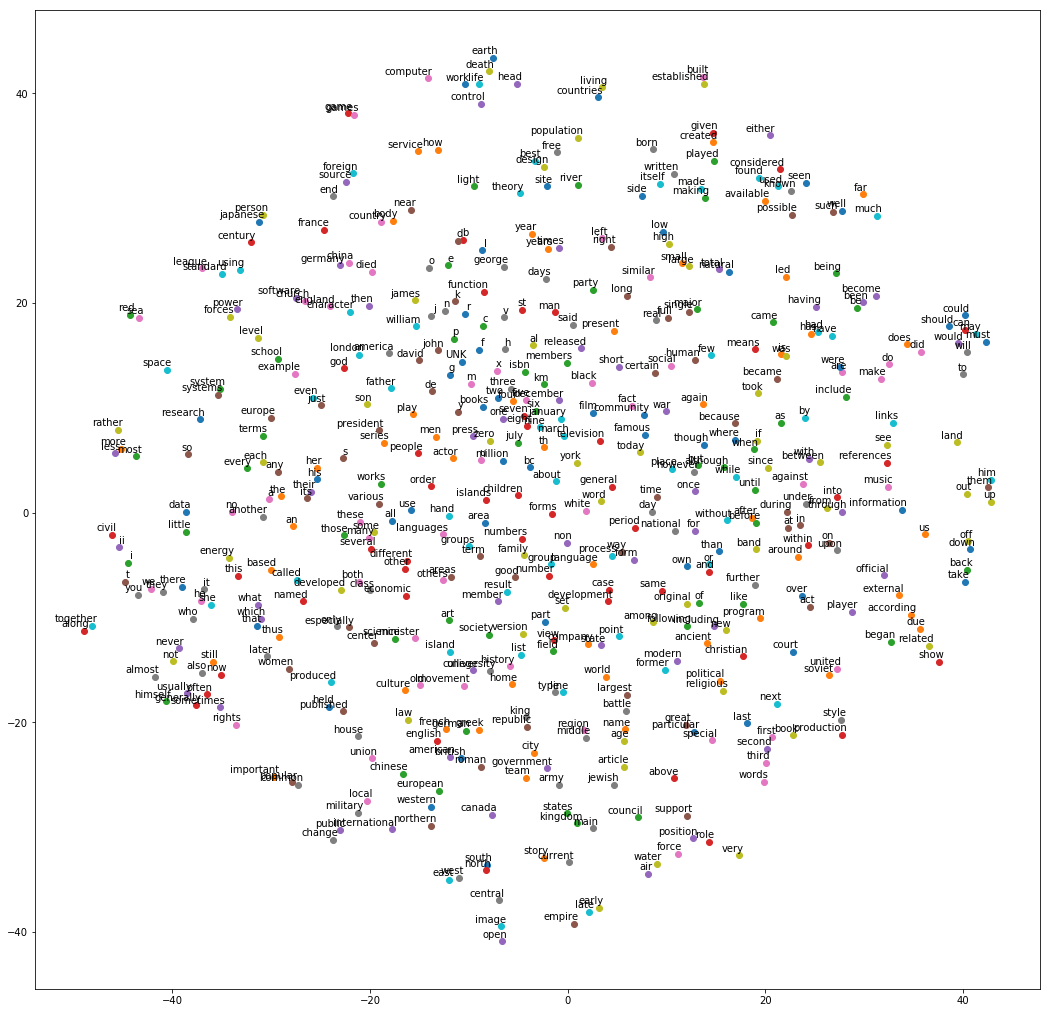

In [11]:
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  #plt.savefig(filename)
  plt.show()

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)